## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [2]:
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


I would remove all the punctuation from the data set since they don't give any insight to the nature of the message. Similarly, common words like "I", "the", "and", etc. don't reveal a unique meaning, so they can be removed. Since this is categorical data, we can transform it into a format that algorithms can use through one-hot encoding. Once this is done, we can then split the data set into testing and training data and run a linear regression to predictive its level of indication of a scam email.

### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [4]:
with open('/content/all_tokens (1).pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

<Axes: >

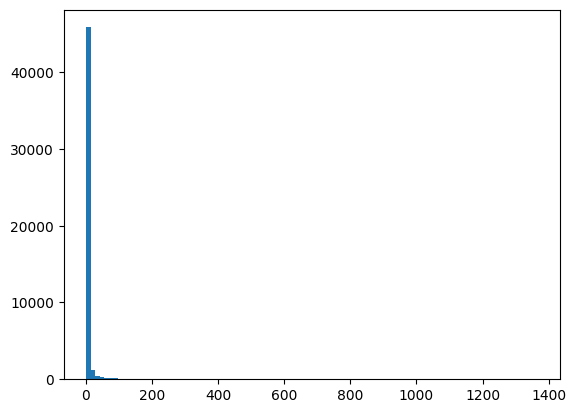

In [5]:
token_df = pd.DataFrame(token_freq,columns=['token','count'])
token_df['count'].hist(grid=False,bins=100)

Many of the tokens only occur once, or only a few times. This causes the graph to be majorly skewed right. We can infer that a token appearing with such low frequency cannot be indicative of a scam email.

### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [10]:
df = pd.read_parquet('/content/Phishing_clean.parquet')
#df = pd.read_csv('/content/Phishing_clean.parquet')

# 1 = scam, 0 = not
y = df['Email Type']

# drop the result from training data
X = df.drop('Email Type',axis=1)

# split data into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=125)

# perform linear regression
lm_0 = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test_0 = lm_0.predict(X_test)
y_hat_train_0 = lm_0.predict(X_train)
print('train: ', r2_score(y_hat_train_0,y_train) )
print('test: ', r2_score(y_hat_test_0,y_test) )

train:  0.6210107280960204
test:  -0.00026838432670373


In [11]:
coefficients = lm_0.coef_
feature_names = lm_0.feature_names_in_
results = pd.DataFrame({'variable': feature_names, 'coefficient': coefficients})
results['abs_coefficient'] = np.abs(results['coefficient'])
sorted_coeffs = results.sort_values('abs_coefficient', ascending=False)
print(sorted_coeffs)

        variable   coefficient  abs_coefficient
710         1997 -1.415784e+13     1.415784e+13
421         1995  1.158467e+13     1.158467e+13
1133         19, -1.025713e+13     1.025713e+13
340         2005 -9.773947e+12     9.773947e+12
1146       -0400 -8.062341e+12     8.062341e+12
...          ...           ...              ...
1399       union  2.822876e-04     2.822876e-04
565         east -2.746582e-04     2.746582e-04
2268     ravages -1.068115e-04     1.068115e-04
457          due -6.484985e-05     6.484985e-05
2709  leadership -6.103516e-05     6.103516e-05

[2711 rows x 3 columns]


On the training set, we have an R^2 of 0.621, while the test set has one of -0.00027. Thus, the model performs well on the training set but not so much on the testing set.

The tokens with the largest coefficients turn out to be numbers, such as 1997, 1995, and 19 being the highest. 3 out of the top 5 seem to be years, but I am unsure of how they fight into the emails. Thus, they are not the most obvious results.

### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

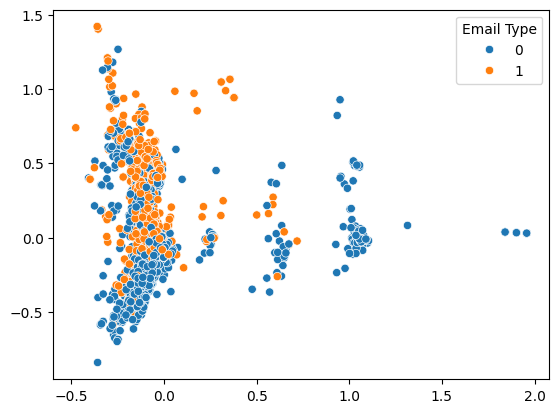

In [12]:
pca = PCA(n_components=2)
pca = pca.fit(X_train)
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

The points that are scam emails tend to have a low first component, with the majority of the group being between -0.5 and 0.0. The second component ranges more, but it tends to be higher. For those that are not scam emails, the first component ranges more, with a majority being low but also with an appearance of different groups increasingly getting higher.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [13]:
# decomposition with 2,610 components
pca = PCA(n_components=2610)
pca = pca.fit(X_train)
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

# linear regression of y on those components
lm = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm.predict(Z_test)
y_hat_train = lm.predict(Z_train)

# compute R^2 on training and test sets
r2_train_score = r2_score(y_hat_train,y_train)
r2_test_score = r2_score(y_hat_test,y_test)

print('train R^2: ', r2_train_score)
print('test R^2: ', r2_test_score)

train R^2:  0.692897536096375
test R^2:  0.5873905973217184


This performance is much better than the other linear regression. The R^2 fpr the training data is 0.693 compared to 0.621. For the test data, it is 0.587 compared to -0.00027. This is a stark improvement for the test set, as it is much more similar to the R^2 of the training set.

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

PCA allows us to use the most important features from a large dataset but reduces the complexity of the model. However, it does this without lossing much information. It also avoids overfitting, which we can see in the improved R^2 for the test score after we used the principal components. Overall, we can avoid have features correlate using PCA and thus avoid multi-colinearity.